In [0]:
% tensorflow_version 2.x

import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

TensorFlow 2.x selected.


# Importing data and building dataset

In [0]:
# Import dataset
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip -d bike_data

--2020-02-02 21:58:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2020-02-02 21:58:14 (1.80 MB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: bike_data/Readme.txt    
  inflating: bike_data/day.csv       
  inflating: bike_data/hour.csv      


In [0]:
df = pd.read_csv('bike_data/hour.csv', index_col='instant')

In [0]:
def select_columns(df):
  cols_to_keep = [       
      'cnt',
      'temp',
      'hum',
      'windspeed',
      'yr',
      'mnth', 
      'hr', 
      'holiday', 
      'weekday', 
      'workingday'
  ]
  df_subset = df[cols_to_keep]
  return df_subset

def onehot_encode_integers(df, excluded_cols):
  df = df.copy()

  int_cols = [col for col in df.select_dtypes(include=['int'])
              if col not in excluded_cols]

  df.loc[:,int_cols] = df.loc[:,int_cols].astype('str')

  df_encoded = pd.get_dummies(df)
  return df_encoded

def normalize_cnt(df):
    df = df.copy()
    df['cnt'] = df['cnt'] / df['cnt'].max()
    return df

In [0]:
dataset = (df
           .pipe(select_columns)
           .pipe(onehot_encode_integers, 
                 excluded_cols=['cnt'])
           .pipe(normalize_cnt)
)

In [0]:
def create_dataset(df, n_deterministic_features, 
                   window_size, forecast_size, 
                   batch_size):
  # Feel free to play with shuffle buffer size
  shuffle_buffer_size = len(df)
  # Total size of window is given by the number of steps to be considered
  # before prediction time + steps that we want to forecast
  total_size = window_size + forecast_size

  data = tf.data.Dataset.from_tensor_slices(df.values)

  # Selecting windows
  data = data.window(total_size, shift=1, drop_remainder=True)
  data = data.flat_map(lambda k: k.batch(total_size))

  # Shuffling data (seed=Answer to the Ultimate Question of Life, the Universe, and Everything)
  data = data.shuffle(shuffle_buffer_size, seed=42)

  # Extracting past features + deterministic future + labels
  data = data.map(lambda k: ((k[:-forecast_size],
                             k[-forecast_size:,-n_deterministic_features:]),
                             k[-forecast_size:,0]))
  
  return data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
# Times at which to split train/validation and validation/test
val_time = 10000
test_time = 14000

# How much data from the past should we need for a forecast?
window_len = 24 * 7 * 3 # Three weeks
# How far ahead do we want to generate forecasts?
forecast_len = 24 * 5 # Five days

# Auxiliary constants
n_total_features = len(dataset.columns) 
n_aleatoric_features = len(['cnt','temp','hum','windspeed'])
n_deterministic_features = n_total_features - n_aleatoric_features

# Splitting dataset into train/val/test
training_data = dataset.iloc[:val_time]
validation_data = dataset.iloc[val_time:test_time]
test_data = dataset.iloc[test_time:]


# Now we get training, validation, and test as tf.data.Dataset objects

batch_size = 32

training_windowed = create_dataset(training_data, 
                                   n_deterministic_features,
                                   window_len,
                                   forecast_len,
                                   batch_size)

validation_windowed = create_dataset(validation_data, 
                                     n_deterministic_features,
                                     window_len,
                                     forecast_len,
                                     batch_size)

test_windowed = create_dataset(test_data, 
                               n_deterministic_features,
                               window_len,
                               forecast_len,
                               batch_size=1)

# Model building/training (point predictions)

In [0]:
latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

history = model.fit(training_windowed,epochs=25, validation_data=validation_windowed)

Epoch 1/25
294/294 [==============================] - 24s 82ms/step - loss: 0.0038 - mae: 0.0592 - val_loss: 0.0075 - val_mae: 0.0988
Epoch 2/25
294/294 [==============================] - 16s 54ms/step - loss: 0.0013 - mae: 0.0340 - val_loss: 0.0080 - val_mae: 0.1040
Epoch 3/25
294/294 [==============================] - 16s 53ms/step - loss: 0.0012 - mae: 0.0316 - val_loss: 0.0075 - val_mae: 0.0988
Epoch 4/25
294/294 [==============================] - 16s 53ms/step - loss: 0.0012 - mae: 0.0306 - val_loss: 0.0076 - val_mae: 0.0988
Epoch 5/25
294/294 [==============================] - 16s 54ms/step - loss: 0.0011 - mae: 0.0299 - val_loss: 0.0084 - val_mae: 0.1042
Epoch 6/25
294/294 [==============================] - 16s 54ms/step - loss: 0.0011 - mae: 0.0295 - val_loss: 0.0067 - val_mae: 0.0893
Epoch 7/25
294/294 [==============================] - 16s 54ms/step - loss: 0.0011 - mae: 0.0290 - val_loss: 0.0071 - val_mae: 0.0935
Epoch 8/25
294/294 [==============================] - 16s 55ms

In [0]:
model.evaluate(test_windowed)

   2756/Unknown - 39s 14ms/step - loss: 0.0057 - mae: 0.0770

[0.005713261897758147, 0.077010304]

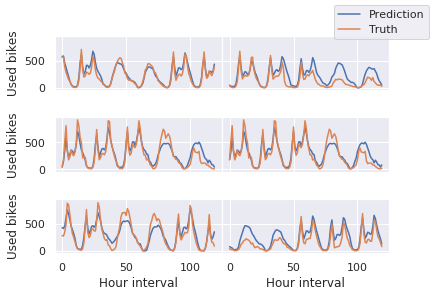

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='all', sharey='all')

# We need to rescale cnt
scaling_factor = df.cnt.max()

for i, data in enumerate(test_windowed.take(6)):
  (past, future), truth = data

  truth = truth * scaling_factor
  pred = model.predict((past,future)) * scaling_factor

  row = i//2
  col = i%2

  ax[row][col].plot(pred.flatten(), label='Prediction')
  ax[row][col].plot(truth.numpy().flatten(),label='Truth')

# Labeling axes
for i in range(2):
  ax[2][i].set_xlabel('Hour interval')
for i in range(3):
  ax[i][0].set_ylabel('Used bikes')

handles, labels = ax[0][0].get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.legend(handles, labels, loc='upper right')

fig.savefig('point_forecasts.svg')
fig.show()

# Forecasting with distributions

In [0]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='relu')(x)
output = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[...,0], 
                         scale=0.01*tf.math.softplus(t[...,1])),
    name='normal_dist')(x)

model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

negloglik = lambda y, p_y: -p_y.log_prob(y)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(loss=negloglik,
              optimizer=optimizer)

history = model.fit(training_windowed,
                    epochs=25, 
                    validation_data=validation_windowed)

Epoch 1/25
294/294 [==============================] - 19s 65ms/step - loss: 18.6529 - val_loss: 4.3520
Epoch 2/25
294/294 [==============================] - 16s 53ms/step - loss: -1.0501 - val_loss: 1.1116
Epoch 3/25
294/294 [==============================] - 16s 54ms/step - loss: -1.2975 - val_loss: 0.5124
Epoch 4/25
294/294 [==============================] - 15s 52ms/step - loss: -1.3973 - val_loss: 0.3837
Epoch 5/25
294/294 [==============================] - 16s 54ms/step - loss: -1.4705 - val_loss: 0.3053
Epoch 6/25
294/294 [==============================] - 16s 53ms/step - loss: -1.5262 - val_loss: 0.2733
Epoch 7/25
294/294 [==============================] - 16s 54ms/step - loss: -1.5719 - val_loss: 0.3065
Epoch 8/25
294/294 [==============================] - 16s 55ms/step - loss: -1.6176 - val_loss: 0.3530
Epoch 9/25
294/294 [==============================] - 16s 54ms/step - loss: -1.6556 - val_loss: 0.5779
Epoch 10/25
294/294 [==============================] - 16s 53ms/step - lo

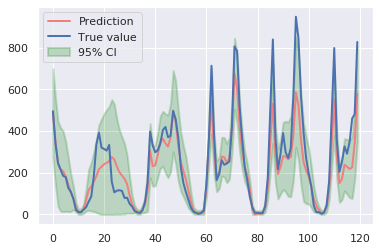

In [0]:
scaling_factor = df.cnt.max()
mean = lambda x: x.mean().numpy().flatten() * scaling_factor
sd = lambda x: x.stddev().numpy().flatten() * scaling_factor

t = np.array(range(forecast_len))

for i, data in enumerate(test_windowed.take(1)):
  (past, future), truth = data
  truth = truth * scaling_factor

  pred = model((past,future))

  plt.fill_between(t, 
                   mean(pred) + 2*sd(pred), 
                   (mean(pred) - 2*sd(pred)).clip(min=0),
                   color = 'green', label = '95% CI', alpha=0.2,
                   linewidth = 2)
  plt.plot(t,mean(pred), label='Prediction', color='lightcoral', linewidth = 2)
  plt.plot(t,truth.numpy().flatten(),label='True value', linewidth = 2)

plt.legend()

plt.savefig('interval_forecasts.svg')
plt.show()